# Información sobre Internaciones en la Ciudad de Buenos Aires.
* Información publicada en https://data.buenosaires.gob.ar/dataset/movimiento-hospitalario

Esta información nos permite saber los servicios, especialidades y hospitales de la ciudad, y los ingresos, altas y defunciones, desde el año 2011 al año 2017.

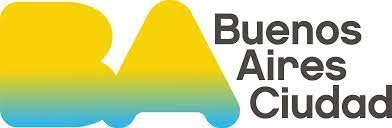

* El Ministerio de Salud del Gobierno de la Ciudad Autónoma de Buenos Aires, necesita evaluar su desempeño en los Hospitales Públicos en el sector de internaciones.
Necesitan saber si la tasa de mortalidad ha aumentado, y en cuáles de sus nosocomios es mayor en el transcurso de estos 6 años para poder tomar las acciones correspondientes.

Nos provee un set de datos con información de los ingresos a internación, altas, defunciones, tasa de mortalidad. Así como también la cantidad de pacientes atendidos, el promedio de camas disponibles, servicio y especialidad, entre otros datos.

Tiene la impresión de que la tasa de mortalidad está relacionada al tipo de servicio de internaciones.

A su vez, ha solicitado un análisis de la cantidad de camas disponibles en los nosocomios, para saber si se requiere ampliar la capacidad de internación. Esto afectaría al presupuesto público, y al sector de Obras Públicas

**Analizaremos lo siguiente**:

* Ha variado la tasa de mortalidad anual?
* Con qué tipo se servicios trabajan los Hospitales?
* Cuál es la tasa de mortalidad por servicio anual?
* Qué servicios tienen mayores ingresos y cuáles mayor tasa de mortalidad?
* Qué Hospitales tienen la mayor tasa de mortalidad?
* Qué variables inciden más en la tasa de mortalidad?
* La cantidad de camas disponibles, corresponde a la cantidad de pacientes atendidos?
* Alcanzan las camas de los Hospitales para el servicio de internación?

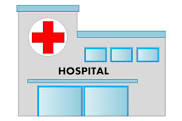

**Librerías**

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import sys
import joblib
import warnings
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Análisis Exploratorio de Datos

In [2]:
df = pd.read_excel('Dfinternacion.xlsx')
df.head(3)
# Tenemos columnas categóricas y numéricas, las categóricas nos brindan el nombre y tipo de Hospital, servicio y especialidad

,SERVICIO,SERVICIO_ID,ESPECIALIDADES,NOM_EFECTOR_BADATA,CODHOSP,TIPHOSP,PASES_A,ING_PASES,ALTAS,DEF,...,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,PORCENTAJE_OCUP,PROMEDIO_PERM,GIRO,TASA_MORT_HOSP,ANIO,SK_ID_EFECTOR,OBSERVACIONES
0,Cirugia,2,Urologia,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,21,325,319,0,...,1820,1292,499,3861,563,2501,0,2011,2164,NaN
1,Cirugia,2,Subtotal Cirugia,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,634,5295,4616,27,...,26327,13295,7213,5425,498,3978,51,2011,2164,NaN
2,Urgencia,10,Terapia Intensiva,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ,HGNRG,INFANT,236,337,3,62,...,5102,1668,1398,8379,1509,2026,1834,2011,2164,NaN


In [3]:
#nuestras columnas son:
df.columns

Index(['SERVICIO', 'SERVICIO_ID', 'ESPECIALIDADES', 'NOM_EFECTOR_BADATA',
       'CODHOSP', 'TIPHOSP', 'PASES_A', 'ING_PASES', 'ALTAS', 'DEF', 'TOTAL',
       'PASES_B', 'EGR_PASES', 'DIAS_CAMAS_DISP', 'PAC_DIA',
       'PROMEDIO_CAMAS_DISP', 'PROMEDIO_PAC_DIA', 'PORCENTAJE_OCUP',
       'PROMEDIO_PERM', 'GIRO', 'TASA_MORT_HOSP', 'ANIO', 'SK_ID_EFECTOR',
       'OBSERVACIONES'],
      dtype='object')

In [4]:
df.describe()

,SERVICIO_ID,PASES_A,ING_PASES,ALTAS,DEF,TOTAL,PASES_B,EGR_PASES,DIAS_CAMAS_DISP,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,PORCENTAJE_OCUP,PROMEDIO_PERM,GIRO,TASA_MORT_HOSP,ANIO,SK_ID_EFECTOR
count,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000,2772.000000
mean,5.782468,283.669553,1578.845960,1245.154401,48.656205,1293.810606,284.419553,1578.230159,19356.187590,13997.920996,3816.824315,3060.290765,4971.269481,1120.784271,3233.679293,406.505411,2013.970779,2132.859668
std,3.030569,491.997242,2545.546298,2110.852652,100.097724,2164.763782,524.225255,2542.600223,41853.813953,33961.745365,10315.681053,8563.420546,3362.145976,2727.485319,4304.574174,750.950895,1.994275,21.081088
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2011.000000,2108.000000
25%,2.000000,24.000000,257.750000,117.000000,0.000000,143.000000,21.000000,258.000000,3448.750000,2194.250000,50.000000,140.500000,815.750000,122.000000,356.500000,0.000000,2012.000000,2119.000000
50%,6.000000,102.000000,588.000000,446.000000,6.000000,468.500000,85.000000,585.500000,7678.500000,4598.000000,1001.000000,857.000000,5939.500000,518.000000,2481.000000,78.000000,2014.000000,2123.000000
75%,9.000000,308.250000,1886.000000,1367.750000,45.000000,1462.000000,269.000000,1898.000000,16917.000000,12244.000000,3005.000000,2253.250000,7739.250000,995.000000,4169.750000,462.500000,2016.000000,2161.000000
max,10.000000,3545.000000,18479.000000,16000.000000,743.000000,16593.000000,3545.000000,18507.000000,367503.000000,322896.000000,100686.000000,88465.000000,12255.000000,28626.000000,56075.000000,7895.000000,2017.000000,2172.000000


In [5]:
print(df.shape)

(2772, 24)


In [6]:
#Buscamos duplicados

df2=df.drop_duplicates()
print(df2.shape)  

#no se observan duplicados, lo vemos comparando con un df2

(2772, 24)


In [7]:
df.isnull()  #búsqueda de datos nulos

,SERVICIO,SERVICIO_ID,ESPECIALIDADES,NOM_EFECTOR_BADATA,CODHOSP,TIPHOSP,PASES_A,ING_PASES,ALTAS,DEF,...,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,PORCENTAJE_OCUP,PROMEDIO_PERM,GIRO,TASA_MORT_HOSP,ANIO,SK_ID_EFECTOR,OBSERVACIONES
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2768,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2769,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2770,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


***Dado que la columna "Observaciones" no será de nuestro interés, no se considera necesario reemplazar o eliminar la misma.*** Definamos las variables:

* SERVICIO y SERVICIO_ID: Corresponde al  servicio de ingreso del paciente en Hospital
* ESPECIALIDADES: tipo de especialidad del servicio
* TOTAL: La sumatoria entres de los pacientes que fallecieron y los que fueron dados de alta 
* ALTAS:cantidad de pacientes dados de alta 
* DEF:cantidad de pacientes fallecidos 
* TASA_MORT_HOSP: Tasa de mortalidad del Hospital 
* PORCENTAJE_OCUP_ porcentaje ocupación Hospital
* ANIO: año de ingreso del paciente
* NOM_EFECTOR_BADATA, CODHOSP,SK_ID_EFECTOR : nombre del Hospital, abreviatura y código.
* PAC_DIA: pacientes diarios
* PROMEDIO_CAMAS_DISP: promedio de camas disponibles
* PROMEDIO_PAC_DIA:promedio de pacientes diarios
* GIRO,PASES_A,ING_PASES: movimientos e/Hospitales
**Para mejor visualización se ha agregado un código a cada Hospital (CODHOSP), y se los ha identificado por tipo de Hospital(TIPHOSP), no se encontraban en la base original

In [8]:
#Trabajaremos ahora con:
df[["SERVICIO","CODHOSP","TOTAL","TIPHOSP","ALTAS","DEF","TASA_MORT_HOSP","ANIO","NOM_EFECTOR_BADATA"]]

,SERVICIO,CODHOSP,TOTAL,TIPHOSP,ALTAS,DEF,TASA_MORT_HOSP,ANIO,NOM_EFECTOR_BADATA
0,Cirugia,HGNRG,319,INFANT,319,0,0,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
1,Cirugia,HGNRG,4643,INFANT,4616,27,51,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
2,Urgencia,HGNRG,65,INFANT,3,62,1834,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
3,Urgencia,HGNRG,65,INFANT,3,62,1834,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
4,Urgencia,HGNRG,9757,INFANT,9633,124,127,2011,HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ
...,...,...,...,...,...,...,...,...,...
2767,Cirugia,HMOYANO,19,PSIQUIAT,16,3,3,2011,HOSPITAL DE SALUD MENTAL BRAULIO MOYANO
2768,Urgencia,HGAJPEN,1363,GAGUDOS,1222,141,4,2012,HOSPITAL GENERAL DE AGUDOS J. A. PENNA
2769,Tocoginecologia,HGAVS,1842,GAGUDOS,1842,0,0,2012,HOSPITAL GENERAL DE AGUDOS D. VELEZ SARSFIELD
2770,Urgencia,HGAVS,0,GAGUDOS,0,0,0,2011,HOSPITAL GENERAL DE AGUDOS D. VELEZ SARSFIELD


**ANÁLISIS DE VARIABLES**

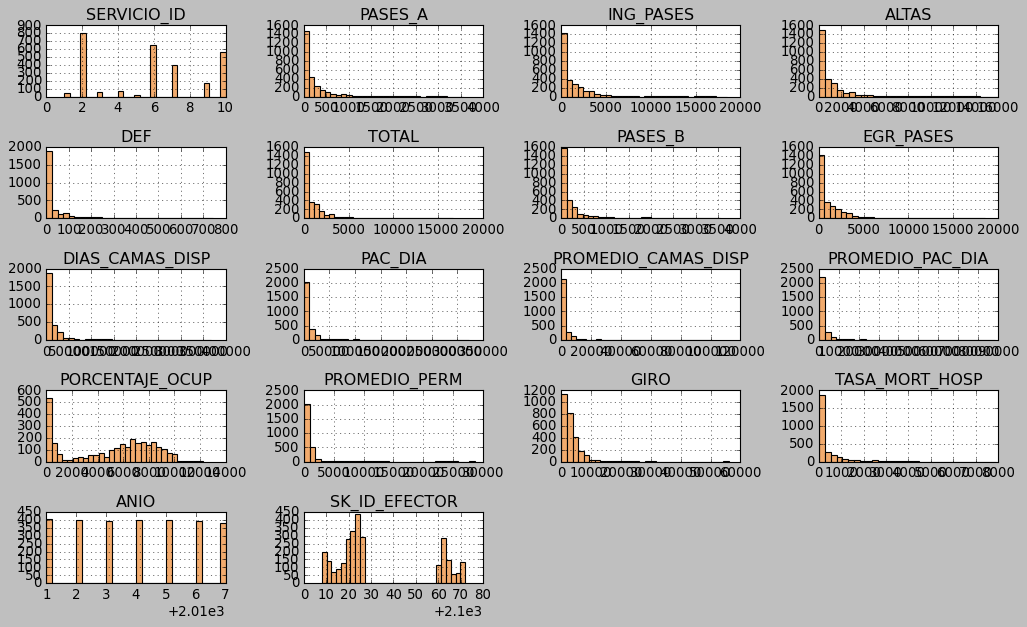

In [31]:
df.iloc[:, 1:].hist(bins = 30, color='#F2AB6D', figsize = (13, 8))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histograma de Mortalidad')

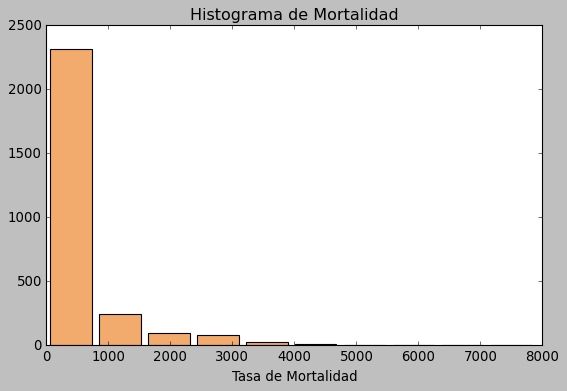

In [30]:
#Realizamos un histograma sobre la tasa de mortalidad
mpl.style.use('classic')
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(x= df.TASA_MORT_HOSP, color='#F2AB6D', rwidth=0.85, orientation='vertical')
ax.set_xlabel('Tasa de Mortalidad')
ax.set_title('Histograma de Mortalidad')

Text(0.5, 1.0, 'Tasa de Mortalidad Anual')

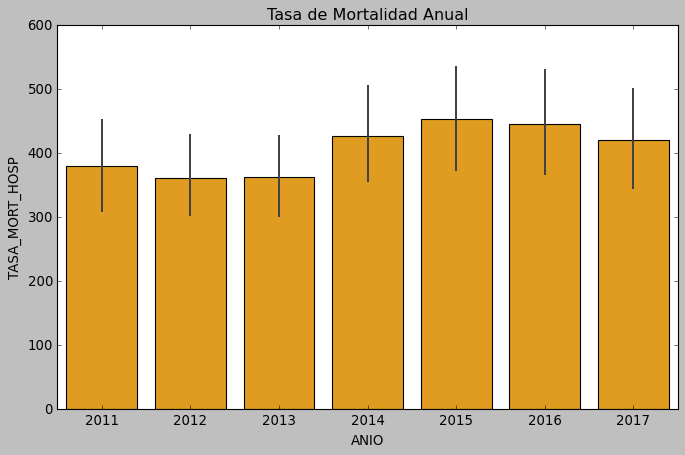

In [34]:
#Tasa de mortalidad anual
plt.figure(figsize=(10,6))
sns.barplot(y='TASA_MORT_HOSP',x='ANIO',color = 'orange',data=df);
plt.title('Tasa de Mortalidad Anual')

In [12]:
#Observamos con qué tipo de servicios trabajan los nosocomios

print(df['SERVICIO'].unique())

['Cirugia' 'Urgencia' 'Pediatria' 'Tocoginecologia' 'Medicina'
 'Internacion De Corta Estadia' 'Area Indiferenciada'
 'Cuidados Genereales - Area Indiferenciada' 'Cuidados Especiales']


Text(0.5, 1.0, 'Defunciones por Servicio Anual')

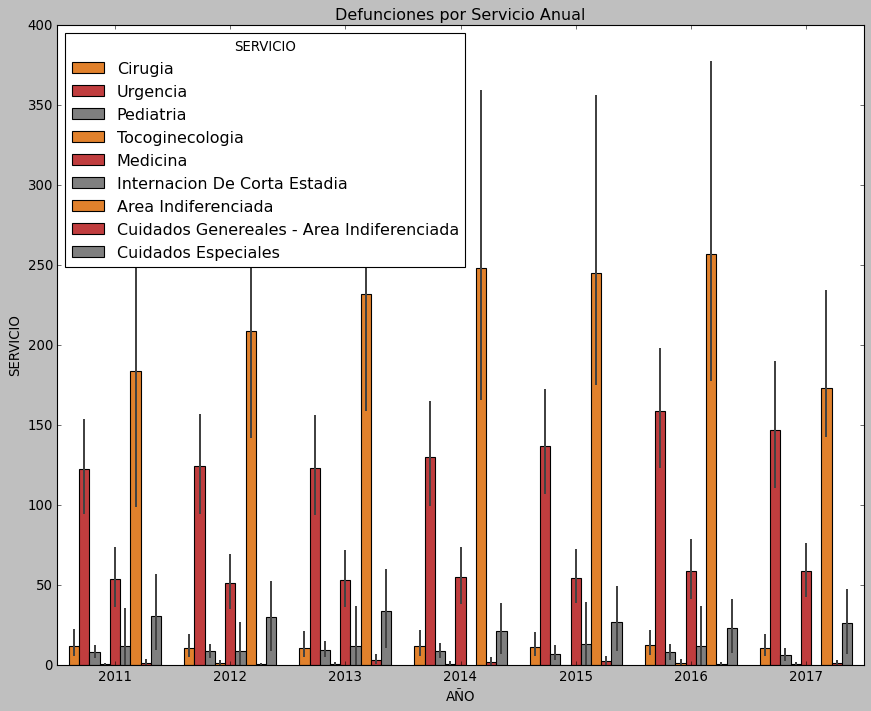

In [53]:

#Analizamos las defunciones por servicio anual

import seaborn as sns
plt.figure(figsize=(13,10))
sns.barplot(y='DEF',x='ANIO',hue='SERVICIO',color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'],data=df);
plt.xlabel('AÑO')
plt.ylabel('SERVICIO')
plt.title('Defunciones por Servicio Anual')

In [23]:
df.groupby('SERVICIO_ID')[['DEF']].sum() 

,DEF
SERVICIO_ID,
1,8954
2,9188
3,1535
4,112
5,172
6,36048
7,3192
9,128
10,75546


Text(0.5, 1.0, 'Tasa de mortal. por Servicio Anual')

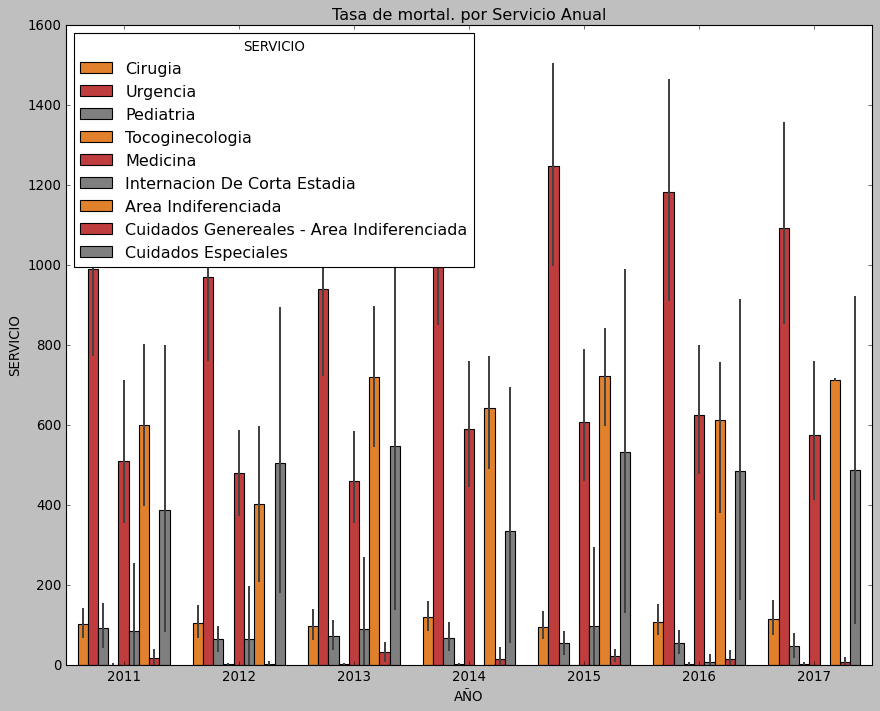

In [54]:
#Y la tasa de mortalidad por servicio anual


import seaborn as sns
plt.figure(figsize=(13,10))
sns.barplot(y='TASA_MORT_HOSP',x='ANIO',hue='SERVICIO',color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'],data=df);
plt.xlabel('AÑO')
plt.ylabel('SERVICIO')
plt.title('Tasa de mortal. por Servicio Anual')

In [21]:
#Los servicios 10-2-6 prevalecen en Tasa de Mortalidad: Medicina- Cirugía -Urgencia
df.groupby('SERVICIO_ID')[['TASA_MORT_HOSP']].sum() 

,TASA_MORT_HOSP
SERVICIO_ID,
1,24949
2,85313
3,26249
4,1108
5,1030
6,359443
7,26184
9,284
10,602273


Text(0, 0.5, 'DEF. Y TASA MORT X SERVICIO')

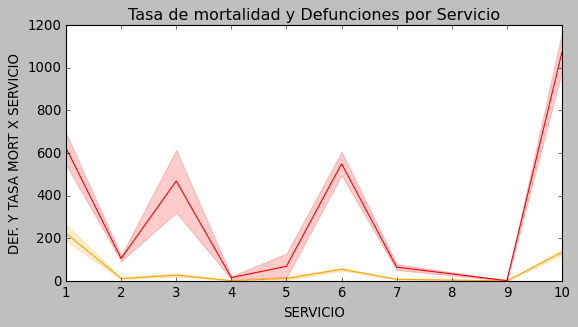

In [58]:
#Podemos visualizar juntas la tasa de mortalidad y las defunciones por Servicio

plt.figure(figsize=(8,4))
may_flights = df
sns.lineplot(data=df, x="SERVICIO_ID", y="DEF",color = 'orange')
plt.xlabel('SERVICIO')
plt.ylabel('DEF. Y TASA MORT X SERVICIO ')
plt.title('Tasa de mortalidad y Defunciones por Servicio')

may_flights = df
sns.lineplot(data=df, x="SERVICIO_ID", y="TASA_MORT_HOSP", color = 'red',)
plt.xlabel('SERVICIO')
plt.ylabel('DEF. Y TASA MORT X SERVICIO')

**Para hacer un análisis más profundo, buscaremos la relación de defunciones por Hospitales**


In [25]:
df.NOM_EFECTOR_BADATA.value_counts()

HOSPITAL GENERAL DE AGUDOS J. M. RAMOS MEJIA                187
HOSPITAL GENERAL DE AGUDOS DR. C. DURAND                    179
HOSPITAL GENERAL DE AGUDOS DONACION F. SANTOJANNI           171
HOSPITAL GENERAL DE AGUDOS B. RIVADAVIA                     163
HOSPITAL GENERAL DE AGUDOS DR C. ARGERICH                   161
HOSPITAL GENERAL DE AGUDOS DR. I. PIROVANO                  153
HOSPITAL GENERAL DE AGUDOS DR. J. A. FERNANDEZ              148
HOSPITAL GENERAL DE AGUDOS DR. T. ALVAREZ                   147
HOSPITAL GENERAL DE NIÑOS PEDRO DE ELIZALDE                 133
HOSPITAL GENERAL DE NIÑOS RICARDO GUTIERREZ                 126
HOSPITAL GENERAL DE AGUDOS J. A. PENNA                      118
HOSPITAL GENERAL DE AGUDOS D. VELEZ SARSFIELD               117
HOSPITAL GENERAL DE AGUDOS DR. E. TORNU                     105
HOSPITAL DE INFECCIOSAS F. MUÑIZ                            100
HOSPITAL DE QUEMADOS DR. ARTURO UMBERTO ILLIA                96
HOSPITAL GENERAL DE AGUDOS P. PIÑERO    

Text(0.5, 1.0, 'Defunciones por Hospital')

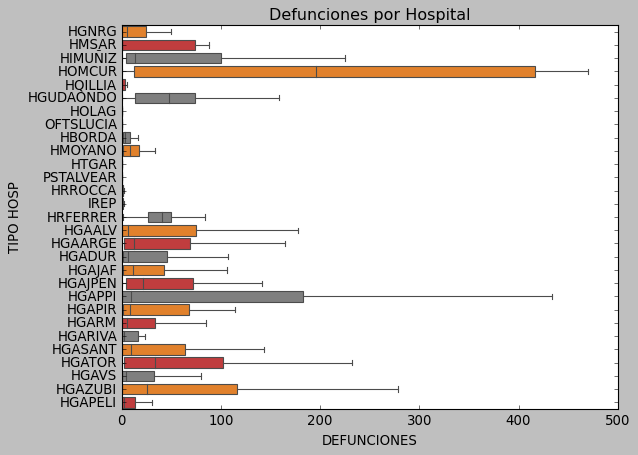

In [55]:
#Lo graficamos utilizando el nombre de Hosp con su abreviatura para ver las defunciones por Hospital
ax = sns.boxplot(x="DEF", y="CODHOSP",color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'], data=df,showfliers=False)
plt.xlabel('DEFUNCIONES')
plt.ylabel('TIPO HOSP')
plt.title('Defunciones por Hospital')

Text(0.5, 1.0, 'Defunciones por Tipo de Hospital')

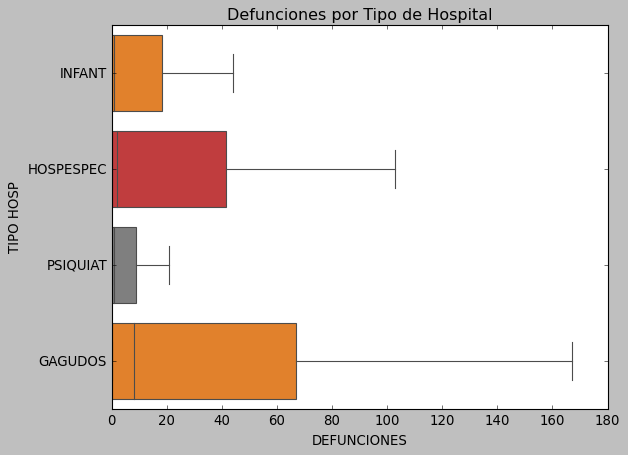

In [59]:
# Realizamos el mismo análisis por tipo de Hospital
ax = sns.boxplot(x="DEF", y="TIPHOSP",color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'], data=df,showfliers=False)
plt.xlabel('DEFUNCIONES')
plt.ylabel('TIPO HOSP')
plt.title('Defunciones por Tipo de Hospital')
#Destacan Hosp. de agudos y de especialidades (quemados, enf.infecciosas,oftalmología,gastoenterología,oncología,rehabilitación)

In [24]:
#Buscamos la tasa de mortalidad dado que la misma depende de los ingresos, teniendo en cuenta el cálculo de este valor
#Las defunciones de gráficos anteriores pueden ser altas, pero quizás tener mayor cantidad de ingreso a internaciones
df.groupby('CODHOSP')[['TASA_MORT_HOSP']].sum()

,TASA_MORT_HOSP
CODHOSP,
HBORDA,8883
HGAALV,57227
HGAARGE,62743
HGADUR,79012
HGAJAF,48815
HGAJPEN,55681
HGAPELI,27357
HGAPIR,63794
HGAPPI,34820


Text(0.5, 1.0, 'Tasa de mort. por Hospital')

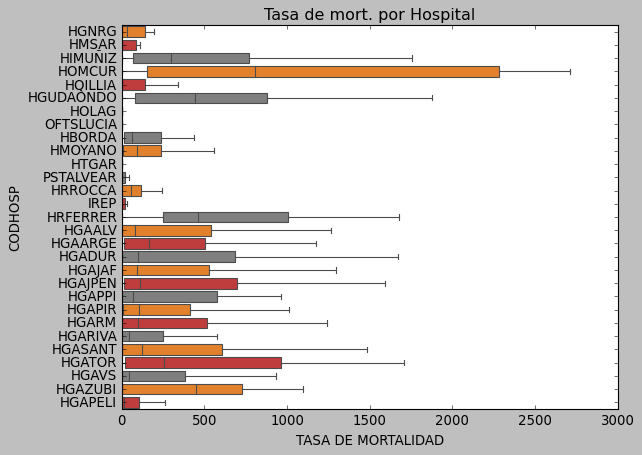

In [60]:
ax = sns.boxplot(x="TASA_MORT_HOSP", y="CODHOSP", color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'],data=df,showfliers=False)
plt.xlabel('TASA DE MORTALIDAD')
plt.ylabel('CODHOSP')
plt.title('Tasa de mort. por Hospital')

Text(0.5, 1.0, 'Tasa de mort. por Tipo de Hospital')

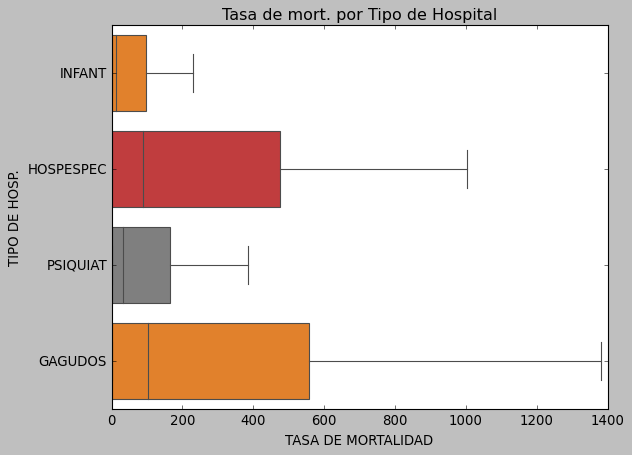

In [61]:
#Buscamos la tasa de mortalidad por tipo de hospital
ax = sns.boxplot(x="TASA_MORT_HOSP", y="TIPHOSP",color = 'orange', palette = ['tab:orange', 'tab:red', 'tab:grey'],data=df,showfliers=False)
plt.xlabel('TASA DE MORTALIDAD')
plt.ylabel('TIPO DE HOSP.')
plt.title('Tasa de mort. por Tipo de Hospital')
#Los Hospitales de Especialidades y de Agudos poseen la mayor tasa de mortalidad

In [22]:
df.groupby('TIPHOSP')[['TOTAL','ALTAS','DEF']].sum()

,TOTAL,ALTAS,DEF
TIPHOSP,,,
GAGUDOS,2462812,2355330,107482
HOSPESPEC,406308,385167,21141
INFANT,667232,661715,5517
PSIQUIAT,50091,49356,735


In [23]:
# Ahora, evaluamos en nuestro análisis los pacientes diarios, el promedio de pacientes y las camas disponibles
df[[ "PAC_DIA","PROMEDIO_CAMAS_DISP","PROMEDIO_PAC_DIA",
    "CODHOSP","TIPHOSP","ANIO","TOTAL"]]

,PAC_DIA,PROMEDIO_CAMAS_DISP,PROMEDIO_PAC_DIA,CODHOSP,TIPHOSP,ANIO,TOTAL
0,1820,1292,499,HGNRG,INFANT,2011,319
1,26327,13295,7213,HGNRG,INFANT,2011,4643
2,5102,1668,1398,HGNRG,INFANT,2011,65
3,5102,1668,1398,HGNRG,INFANT,2011,65
4,79283,31812,21721,HGNRG,INFANT,2011,9757
...,...,...,...,...,...,...,...
2767,4947,32,13,HMOYANO,PSIQUIAT,2011,19
2768,6252,17,17,HGAJPEN,GAGUDOS,2012,1363
2769,6080,24,16,HGAVS,GAGUDOS,2012,1842
2770,6,0,0,HGAVS,GAGUDOS,2011,0


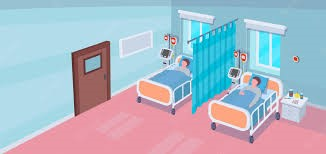

Text(0, 0.5, 'Promedio de camas por pacientes atendidos')

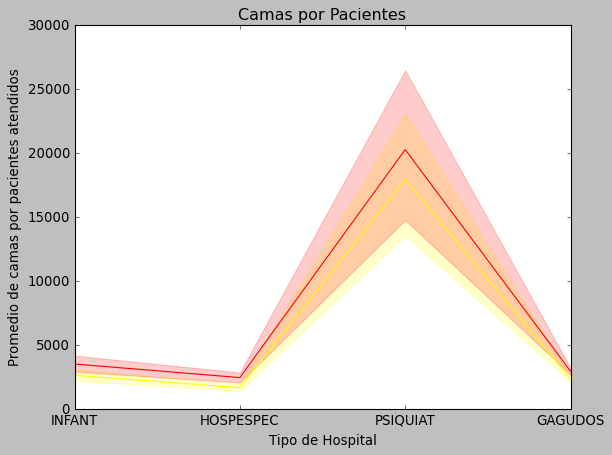

In [66]:
# Analizamos el promedio de camas por el promedio de pacientes atendidos
may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_PAC_DIA",color = 'yellow')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas por pacientes atendidos')
plt.title('Camas por Pacientes')

may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_CAMAS_DISP",color = 'red')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas por pacientes atendidos')
#Observamos que la cantidad de camas disponibles supera levemente la cantidad de pacientes.
#Importante tener en cuenta que no todas las consultas devienen en una internación.

Text(0, 0.5, 'Promedio de camas y Total intern')

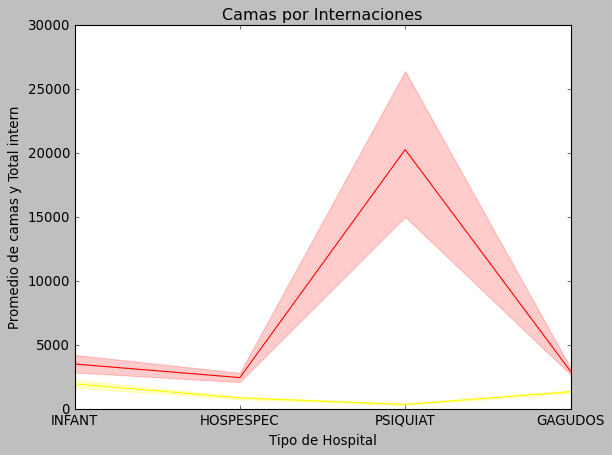

In [70]:
#Veamos ahora, según el total de internaciones, si se dispone de la cantidad de camas suficientes
may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="TOTAL",color = 'yellow')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas y Total intern')
plt.title('Camas por Internaciones')

may_flights = df
sns.lineplot(data=df, x="TIPHOSP", y="PROMEDIO_CAMAS_DISP",color = 'red')
plt.xlabel('Tipo de Hospital')
plt.ylabel('Promedio de camas y Total intern')
#El siguiente gráfico nos demuestra que las internaciones son menores a las camas disponibles

**ANALIZAMOS LA CORRELACIÓN DE NUESTRAS VARIABLES**

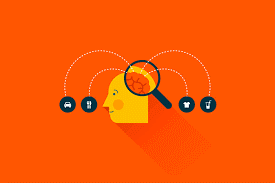

***Nos quedaremos sólo con nuestras variables numéricas**

In [26]:
df = df.drop(columns=['SERVICIO', 'ESPECIALIDADES','NOM_EFECTOR_BADATA', 'CODHOSP','TIPHOSP','OBSERVACIONES'])

#El nombre de los Hospitales está definido por"SK_ID_EFECTOR"
#El nombre de los Servicios por "Servicio ID"

In [27]:
df.columns

Index(['SERVICIO_ID', 'PASES_A', 'ING_PASES', 'ALTAS', 'DEF', 'TOTAL',
       'PASES_B', 'EGR_PASES', 'DIAS_CAMAS_DISP', 'PAC_DIA',
       'PROMEDIO_CAMAS_DISP', 'PROMEDIO_PAC_DIA', 'PORCENTAJE_OCUP',
       'PROMEDIO_PERM', 'GIRO', 'TASA_MORT_HOSP', 'ANIO', 'SK_ID_EFECTOR'],
      dtype='object')

***Hasta el momento nuestra mayor atención fue sobre la tasa de mortalidad relacionada a Hospitales y Servicios. ***
***Veamos la distribución por ambos***

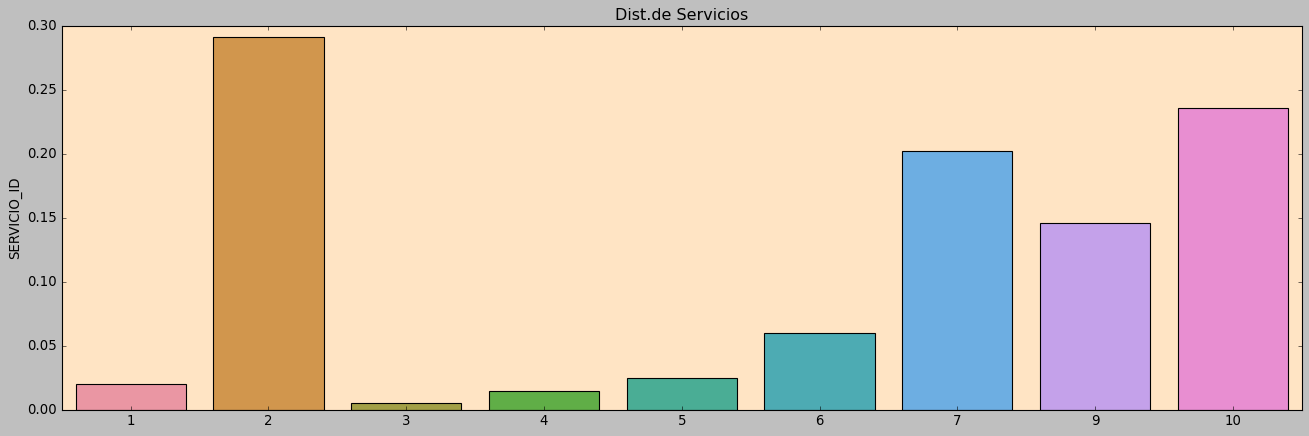

In [79]:
plt.figure(figsize=(20,6))
x=df["SERVICIO_ID"].unique()
y=df["SERVICIO_ID"].value_counts()/df["SERVICIO_ID"].value_counts().sum()
ax=sns.barplot(x=x,y=y)
ax.set_facecolor('bisque')
ax.set_title("Distribucion por SERVICIO_ID")
plt.title('Dist.de Servicios')
plt.show()

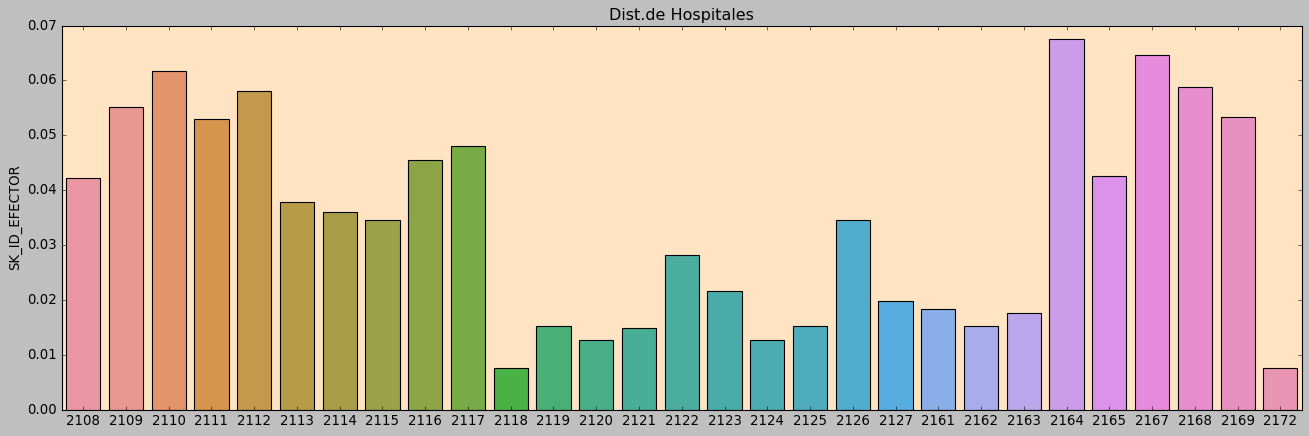

In [80]:
plt.figure(figsize=(20,6))
x=df["SK_ID_EFECTOR"].unique()
y=df["SK_ID_EFECTOR"].value_counts()/df["SK_ID_EFECTOR"].value_counts().sum()
ax=sns.barplot(x=x,y=y)
ax.set_facecolor('bisque')
ax.set_title("Distribucion por Hospital")
plt.title('Dist.de Hospitales')
plt.show()

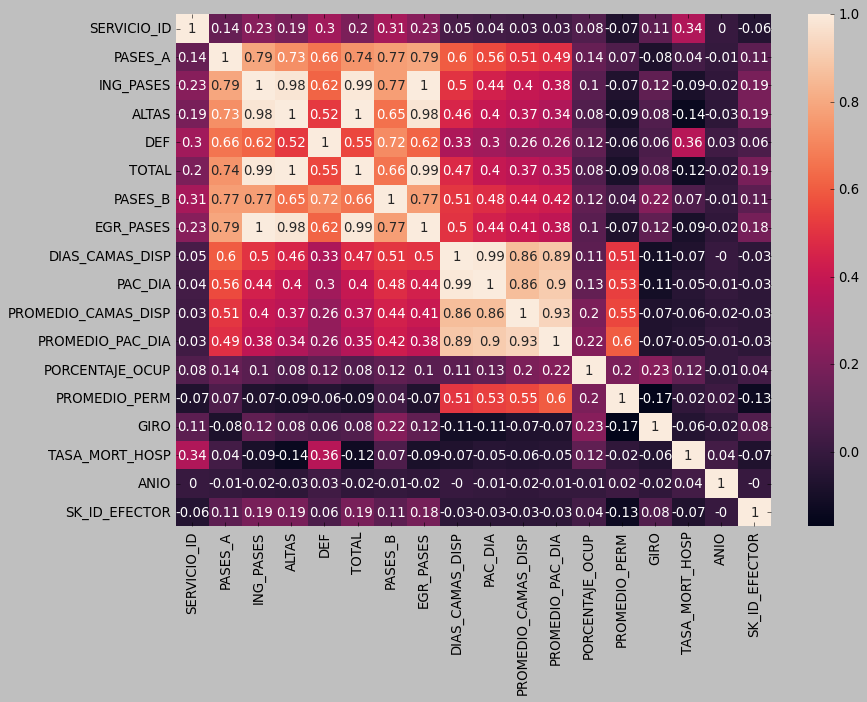

In [31]:
correlation_matrix = df.corr().round(2)
correlation_matrix

plt.figure(figsize=(12,8))
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()
#Vemos que DEF y servicio_id son las variables más relacionadas a la Tasa de Mortalidad, seguidas de PORCENTAJE_OCUP

<AxesSubplot:xlabel='TASA_MORT_HOSP', ylabel='PORCENTAJE_OCUP'>

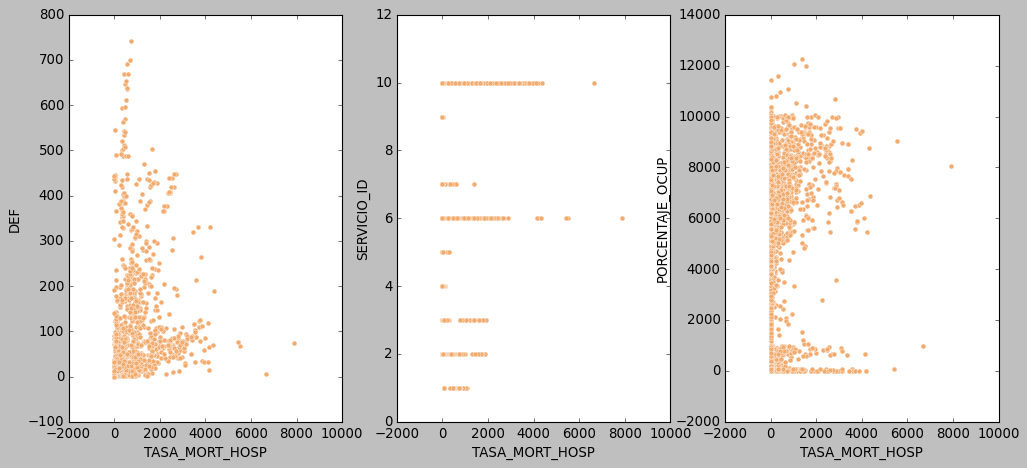

In [105]:
plt.figure(figsize=(15,14))
plt.subplot(2,3,1)
sns.scatterplot(x="TASA_MORT_HOSP",y="DEF",data=df,color='#F2AB6D')
plt.subplot(2,3,2)
sns.scatterplot(x="TASA_MORT_HOSP",y="SERVICIO_ID",data=df,color='#F2AB6D')
plt.subplot(2,3,3)
sns.scatterplot(x="TASA_MORT_HOSP",y="PORCENTAJE_OCUP",data=df,color='#F2AB6D')



# **Interpretación y Conclusiones**




* La tasa de mortalidad comienza a incrementarse en el 2013 con un pico en el 2015 y un leve descenso al final de los 2 años.

* Se registra mayor tasa de mortalidad en CIRUGIA,MEDICINA y URGENCIA.

* Los Hospitales con mayor tasa de mortalidad son: HOSPITAL SANTOJANNI, HOSPITAL DE INFECCIOSAS F. MUÑIZ,HOSPITAL GENERAL DE AGUDOS DR. E. TORNU.

* Concluímos que Los Hospitales de Especialidades y de Agudos poseen la mayor tasa de mortalidad

* En cuanto a la disponibilidad de camas, son muy superiores a la cantidad de internaciones, y sobre todo en los Hospitales de Salud mental.

* Lo que más incide en la Tasa de Mortalidad es DEF y SERVICIO_ID y PORCENTAJE_OCUP